# Case Study 1: Habitat Suitability and Potential Distribution Modeling of Fairy Pitta (Pitta nympha) Using Presence-Only Data

In [1]:
import ee
import geemap
import geemap.colormaps as cm

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Earth Engine Authentication
# ee.Authenticate()

# Initializing Earth Engine
ee.Initialize()

In [3]:
# Creating an Empty geemap Map Object
Map = geemap.Map()

## 1. Add Species Occurrence Data

In [4]:
# Input File Path
input_gpkg_file = 'pitta_nympha_data.gpkg'

# Load GeoPackage File
gdf = gpd.read_file(input_gpkg_file)[["species", "year", "month", "geometry"]]

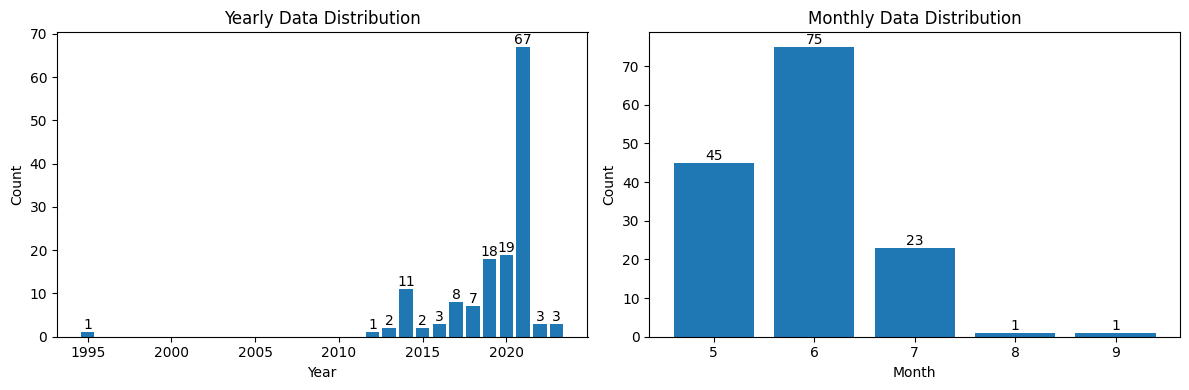

In [5]:
def plot_data_distribution(gdf):
    
    # Yearly Data Distribution Graph (Left)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')
    
    # Display Data Count Inside the Bar Graph
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')
    
    # Monthly Data Distribution Graph (Right)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')
    
    # Display Data Count Inside the Bar Graph
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # Set X-axis Ticks in Integer Format
    plt.xticks(month_counts.index, map(int, month_counts.index))
    
    # Display Graphs
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

plot_data_distribution(gdf)

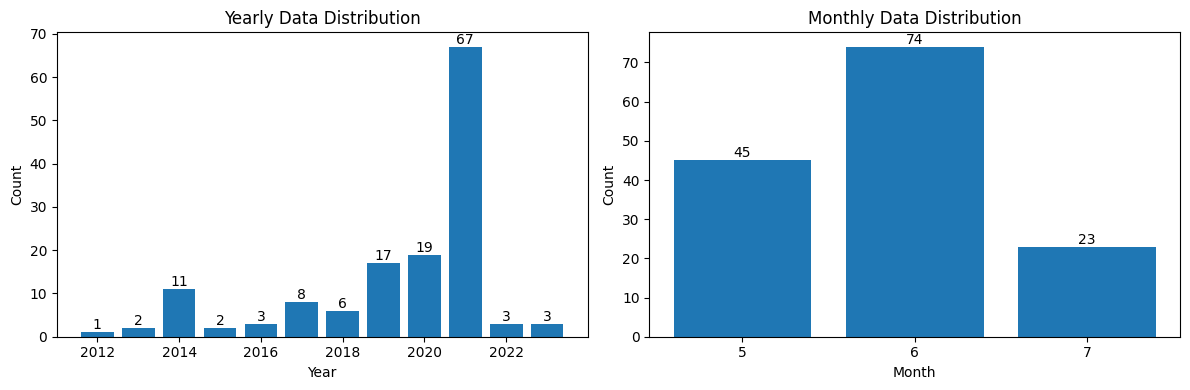

In [6]:
# Filtering Based on Year and Month
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

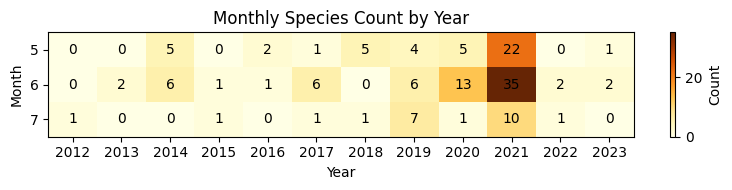

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     0     1
6         0     2     6     1     1     6     0     6    13    35     2     2
7         1     0     0     1     0     1     1     7     1    10     1     0


In [7]:
def plot_heatmap_from_gdf(gdf):
    # Calculate Required Statistics
    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)
    
    # Visualize Statistics with a Heatmap
    plt.figure(figsize=(8, 2))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # Display Numerical Values on Each Pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()

# Call the Heatmap Graph Output Function
plot_heatmap_from_gdf(filtered_gdf)

# Outputting the Statistics Table
print(filtered_gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

In [8]:
# Output File Path
output_shapefile = 'pitta_nympha_data.shp'

# Save as Shapefile
filtered_gdf.to_file(output_shapefile)

# Adding Raw Presence Data
data_raw = geemap.shp_to_ee(output_shapefile)

In [9]:
# Set Working Spatial Resolution (m)
GrainSize = 1000

def remove_duplicates(data, GrainSize):
    # Randomly Select Only One Presence Record per Pixel at the Chosen Spatial Resolution (1km)
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

In [10]:
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 142
Final data size: 95


In [11]:
vis_params = {'color': 'blue'}
Map.addLayer(data_raw, vis_params, 'Original data')
Map.centerObject(data_raw.geometry(), 7)

vis_params = {'color': 'red'}
Map.addLayer(Data, vis_params, 'Final data')
Map.centerObject(Data.geometry(), 7)

Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## Define Area of Interest

In [12]:
# Define AOI (Area of Interest)
AOI = Data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Add Study Area Boundary to the Map
outline = ee.Image().byte().paint(featureCollection=AOI, color=1, width=3)
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 3. Add Predictive Variables

In [13]:
# WorldClim BIO Variables V1 (1km): A total of 19 climate variables
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: Digital elevation data
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# Percent Tree Cover: Median between 2003 and 2020
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

In [14]:
# Combining Bands into a Single Multi-Band Image
predictors = BIO.addBands(Terrain).addBands(MedianPTC)

# Masking Ocean Pixels in Predictive Variable Images
watermask =  Terrain.select('elevation').gt(0) # Creating Water Body Mask
predictors = predictors.updateMask(watermask).clip(AOI) # Masking Ocean Pixels & Clipping to the Area of Interest

In [15]:
# Extracting Covariate Values between Multi-Band Predictive Images at 5000 Random Locations
DataCor = predictors.sample(scale=GrainSize, numPixels=5000, geometries=True) # Generating 5000 Random Locations
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=16) # Extracting Covariate Values

In [16]:
# Converting Covariate Values from ee to DataFrame
PixelVals_df = geemap.ee_to_pandas(PixelVals)
PixelVals_df.head()

,elevation,bio08,bio19,bio09,slope,bio10,hillshade,aspect,bio06,bio17,...,bio05,bio16,bio02,bio13,bio03,bio14,bio11,PTC,bio01,bio12
0,31,247,112,27,0,247,181,296,-27,112,...,304,563,89,218,26,33,27,7.0,139,1162
1,329,216,62,-57,6,222,188,203,-146,62,...,281,836,119,401,27,17,-57,51.0,90,1289
2,586,210,95,-51,10,210,190,198,-127,95,...,269,785,117,340,29,30,-51,63.0,85,1400
3,143,226,65,-33,3,232,173,64,-109,65,...,287,897,106,439,26,18,-33,19.5,106,1403
4,367,217,50,-64,4,217,191,251,-141,50,...,276,665,108,323,25,14,-64,28.0,84,1067


In [17]:
columns = PixelVals_df.columns
columns

Index(['elevation', 'bio08', 'bio19', 'bio09', 'slope', 'bio10', 'hillshade',
       'aspect', 'bio06', 'bio17', 'bio07', 'bio18', 'bio04', 'bio15', 'bio05',
       'bio16', 'bio02', 'bio13', 'bio03', 'bio14', 'bio11', 'PTC', 'bio01',
       'bio12'],
      dtype='object')

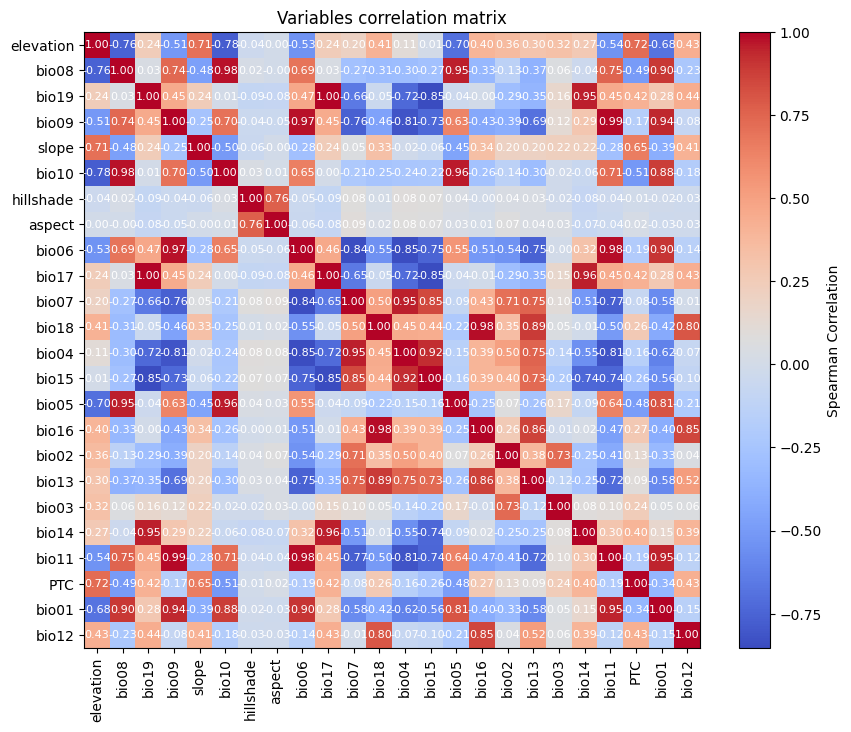

In [18]:
def plot_correlation_heatmap(dataframe, h_size=10):
    # Calculate Spearman Correlation Coefficients
    correlation_matrix = dataframe.corr(method="spearman")

    # Draw Heatmap
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # Display Numerical Values on Heatmap
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)  # fontsize 조정

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

# Heatmap of Variable Correlation Matrix
plot_correlation_heatmap(PixelVals_df)

In [19]:
def filter_variables_by_vif(dataframe, threshold=10):
    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]
    
    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
        
        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)
        
        if max_vif < threshold:
            break
        
        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")
        
        del remaining_columns[max_vif_index]
    
    filtered_data = dataframe[remaining_columns]
    return filtered_data

# Filtering Using VIF (Variance Inflation Factor)
filtered_PixelVals_df = filter_variables_by_vif(PixelVals_df)
bands = filtered_PixelVals_df.columns.tolist()
predictors = predictors.select(bands)
print('Bands:', bands)

Removing 'bio06' with VIF inf
Removing 'bio04' with VIF 213143.75
Removing 'bio10' with VIF 68437.04
Removing 'bio17' with VIF 48555.55
Removing 'bio05' with VIF 32374.85
Removing 'bio07' with VIF 22348.86
Removing 'bio01' with VIF 9725.41
Removing 'bio16' with VIF 3785.62
Removing 'bio03' with VIF 2515.02
Removing 'bio18' with VIF 1791.83
Removing 'bio08' with VIF 1383.23
Removing 'bio12' with VIF 618.77
Removing 'bio19' with VIF 488.40
Removing 'bio15' with VIF 340.60
Removing 'hillshade' with VIF 120.15
Removing 'bio13' with VIF 49.94
Removing 'bio11' with VIF 35.68
Removing 'bio02' with VIF 15.55
Bands: ['elevation', 'bio09', 'slope', 'aspect', 'bio14', 'PTC']


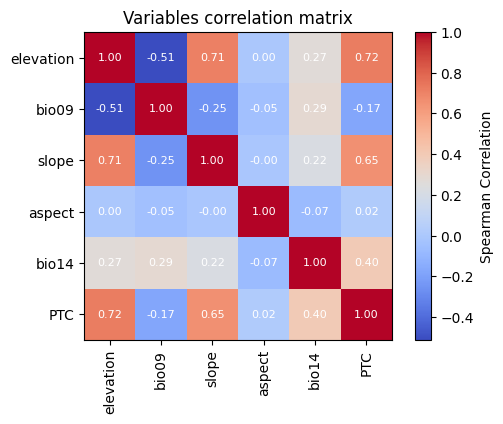

In [20]:
# Heatmap of Variable Correlation Matrix
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

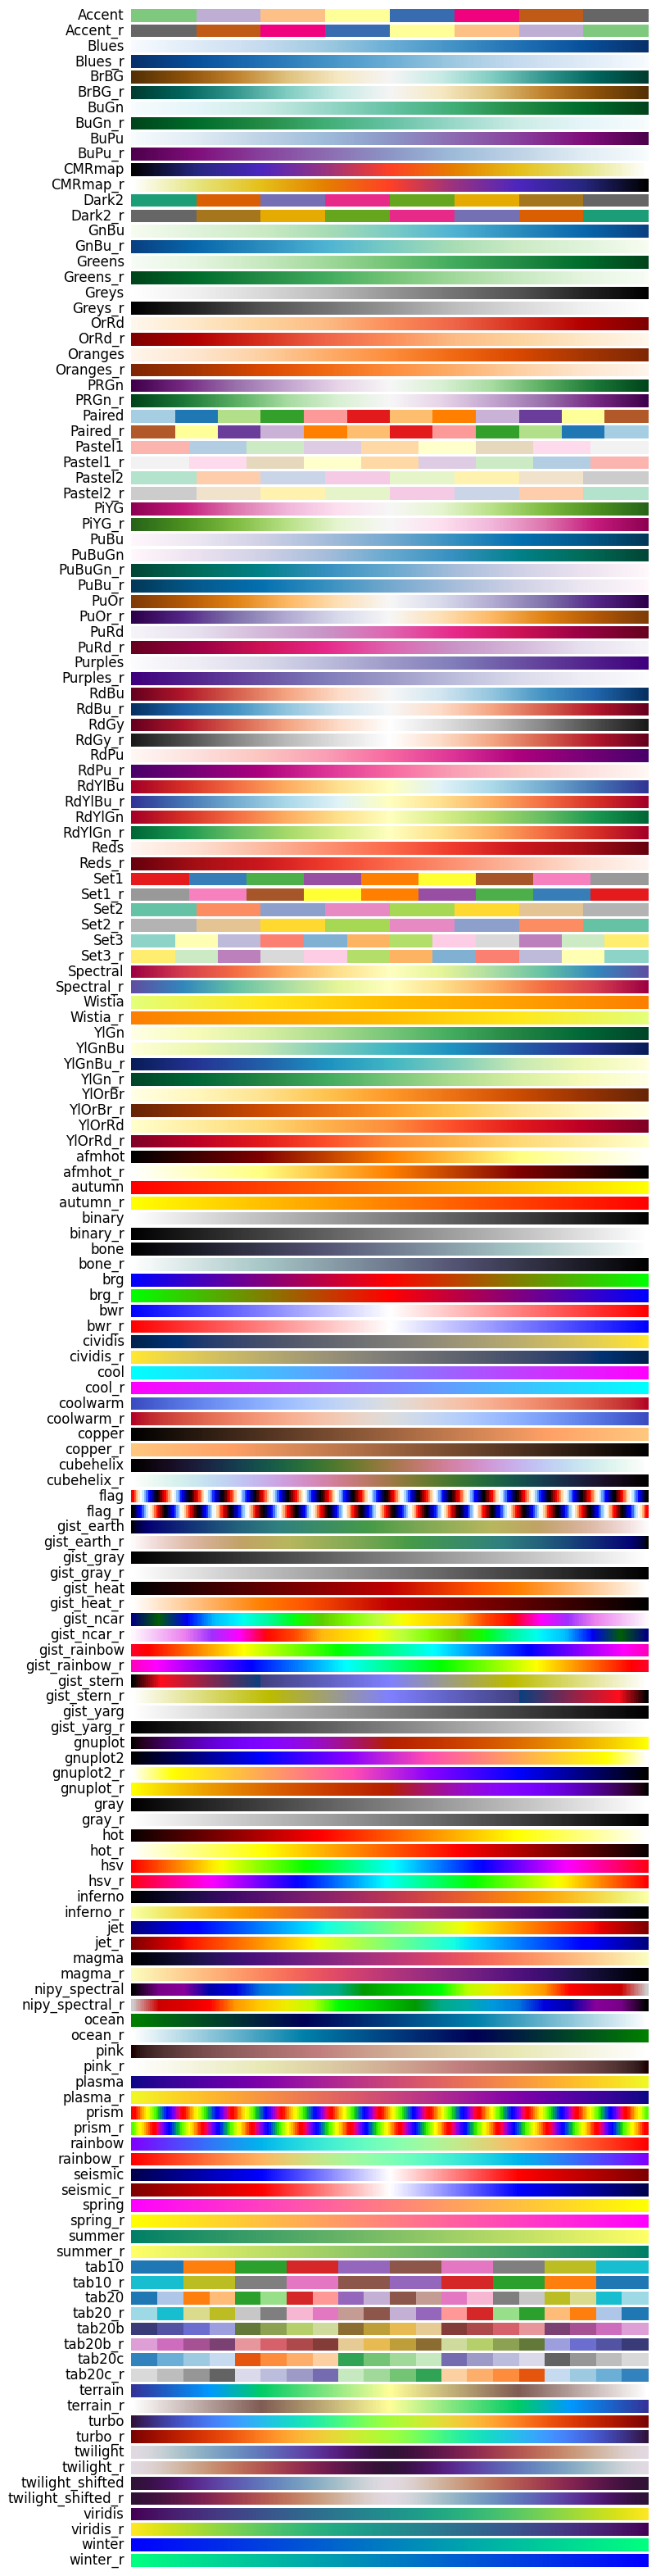

In [21]:
cm.plot_colormaps(width=8.0, height=0.2)

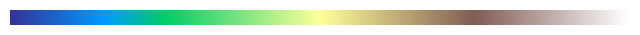

In [22]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [23]:
# elevation
Map = geemap.Map()
vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# Minimum and Maximum Values of bio09
min_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Minimum Value: {'bio09': -10.9}
Maximum Value: {'bio09': 13.5}


In [25]:
# bio09
Map = geemap.Map()
vis_params = {'min': -11, 'max': 14, 'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, 'bio09')
Map.add_colorbar(vis_params, label="Mean temperature of driest quarter (℃)", orientation="vertical", layer_name="bio09")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
# slope
Map = geemap.Map()
vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
# aspect
Map = geemap.Map()
vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [28]:
# Minimum and Maximum Values of bio14
# min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
# max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()
# print("Minimum Value:", min_val)
# print("Maximum Value:", max_val)

# bio14
Map = geemap.Map()
vis_params = {'bands':['bio14'], 'min': 0, 'max': 90, 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
# PTC
Map = geemap.Map()
vis_params = {'bands':['PTC'], 'min': 1, 'max': 100, 'palette': ['bbe029', '0a9501', '074b03']}
Map.addLayer(predictors, vis_params, 'PTC')
Map.add_colorbar(vis_params, label="Percent Tree Cover (%)", orientation="vertical", layer_name="PTC")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 4. Generate Pseudo-Absence Data

### 4.1. Generate Random Pseudo-Absence Data in the Entire Area of Interest

In [30]:
# AreaForPA
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
AreaForPA = presence_mask.updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

### 4.2. Generate Spatially Constrained Pseudo-Absence Data (Buffer around Occurrences)

In [31]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
presence_buffer_mask = Data.geometry().buffer(distance=50000, maxError=1000)
AreaForPA = presence_mask.clip(presence_buffer_mask).updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3. Generate Environmental Pseudo-Absence Data (Environmental Profiling)

In [32]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()

# Extracting Predictive Variable Values from a Random Subset of Occurrence Data
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# Training k-Means Clustering
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

# Assigning Pixels Using the Trained Clusterer
Clresult = predictors.cluster(clusterer)

# Obtaining Cluster IDs Similar to Occurrence Data
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
# Using the Opposite Cluster, Defining Allowable Area for Random Pseudo-Absences
clustID = ee.FeatureCollection(clustID).reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [33]:
# Generating Grid for Spatial Block Cross-Validation
def makeGrid(geometry, scale):
    # Creating Degree-by-Degree Longitude & Latitude Images
    lonLat = ee.Image.pixelLonLat()
    # Integerizing Longitude & Latitude Images
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()
    
    return lonGrid.multiply(latGrid).reduceToVectors(
        # Creating Grid with Grid Cells Containing Geometry Boundaries
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map()
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 5. Fit SDM Model

In [34]:
def SDM(x):
    Seed = ee.Number(x)

    # Random Block Splitting for Training and Validation
    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split)) # Training Grid
    TestingGrid = GRID.filter(ee.Filter.gte('random', split)) # Validation Grid
    
    # Presence Points
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid)) # Training Presence Points
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid)) # Validation Presence Points
    
    # Random Pseudo-Absence Points
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    # Random Pseudo-Absence Points Matching the Number of Training Presence Points
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))
    
    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    # Random Pseudo-Absence Points Matching the Number of Validation Presence Points
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    # Merging Training and Testing Points
    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints) # Training Points
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints) # Testing Points

    # Extracting Covariate Values from Predictive Variable Images at Training Points
    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=16,
                                              geometries=True)

    # Random Forest classifier
    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500, # Number of Decision Trees to Generate
        variablesPerSplit=None, # Number of Features to Consider per Split. Default: Square Root of the Number of Features
        minLeafPopulation=10, # Generating Nodes Containing at Least This Number of Points in the Training Set
        bagFraction=0.5, # Input Fraction per Tree
        maxNodes=None, # Maximum Number of Leaf Nodes per Tree. Default: Unlimited
        seed=Seed # Randomization Seed
    )
    
    # Presence probability
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)
    
    # Binary presence/absence map
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)

    return [ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition], ClassifierPr

## 6. Calculate Variable Importance

In [35]:
split = 0.70  # Split the data into 70% for model fitting and 30% for model validation
numiter = 10 # Number of iterations

# runif = lambda length: [random.randint(1, 1000) for _ in range(length)] # seed
# results = ee.List(runif(numiter)).map(SDM).flatten()

results_list = [] # Initialize the SDM results list
importances_list = [] # Initialize the variable importance list

for item in [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]:
    result, trained = SDM(item)

    # Accumulate SDM results list
    results_list.extend(result)

    # Accumulate variable importance list
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# Accumulate SDM results
results = ee.List(results_list).flatten()

# Extract individual variable importance values into a list
variables = [item[0] for item in importances_list]
importances = [item[1] for item in importances_list]

# Calculate the average variable importance
average_importances = {}
for variable in set(variables):
    indices = [i for i, var in enumerate(variables) if var == variable]
    average_importance = np.mean([importances[i] for i in indices])
    average_importances[variable] = average_importance

# Print the average variable importance
for variable, avg_importance in average_importances.items():
    print(f"{variable}: {avg_importance}")

aspect: 3.722224972595891
bio14: 6.250779258945053
elevation: 59.412175503770165
bio09: 17.23805871882852
PTC: 22.578786069539074
slope: 12.964208580184746


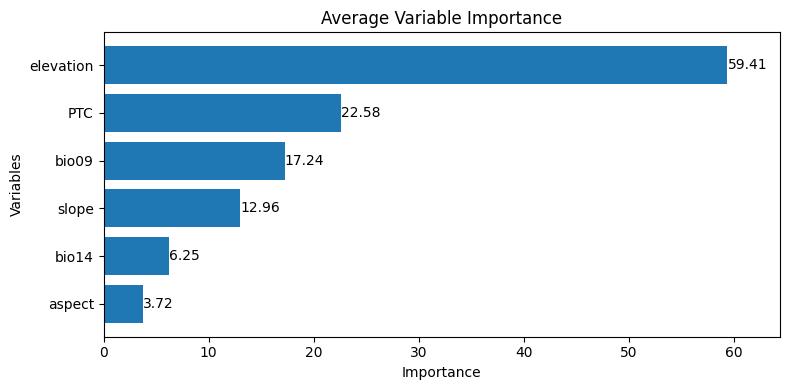

In [36]:
# Sort in descending order of variable importance
sorted_importances = sorted(average_importances.items(), key=lambda x: x[1], reverse=False)
variables = [item[0] for item in sorted_importances]
avg_importances = [item[1] for item in sorted_importances]

# Adjust the size of the graph
plt.figure(figsize=(8, 4))  # Resize as desired

# Display the average importance using a bar graph
plt.barh(variables, avg_importances)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Average Variable Importance')

# Display numerical values above the bars
for i, v in enumerate(avg_importances):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

# Adjust the x-axis range
plt.xlim(0, max(avg_importances) + 5)  # Adjust the range as desired

plt.tight_layout()
plt.savefig('variable_importance_plot.png')
plt.show()

# 7. Predict with SDM Model

In [37]:
# Habitat suitability map
images = ee.List.sequence(0, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [38]:
# Potential distribution map
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

# 8. Accuracy Assessment

In [39]:
# Extract the validation dataset
TestingDatasets = (ee.List.sequence(3, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x)))

# Check if there are enough occurrences and randomly non-occurrence points for model validation
def get_sizes(x):
    fc = ee.FeatureCollection(TestingDatasets.get(x))
    presence_size = fc.filter(ee.Filter.eq('PresAbs', 1)).size()
    pseudo_absence_size = fc.filter(ee.Filter.eq('PresAbs', 0)).size()
    return ee.List([presence_size, pseudo_absence_size])

print('Number of presence and pseudo-absence points for model validation',
      ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_sizes).getInfo())

Number of presence and pseudo-absence points for model validation [[35, 27], [18, 18], [43, 27], [47, 27], [21, 16], [44, 35], [12, 12], [51, 26], [20, 20], [31, 9]]


In [40]:
%%time

# Estimate sensitivity, specificity, and precision
def getAcc(img, TP, GrainSize=GrainSize):
    Pr_Prob_Vals = img.sampleRegions(collection=TP, properties=['PresAbs'], scale=GrainSize, tileScale=16)   
    seq = ee.List.sequence(start=0, end=1, count=25)
    def calculate_metrics(cutoff):
        Pres = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 1)
        # Sensitivity: True Positive and True Positive Rate
        TP = ee.Number(Pres.filterMetadata('classification', 'greater_than', cutoff).size())
        TPR = TP.divide(Pres.size())
        Abs = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 0)
        
        # False Negative
        FN = ee.Number(Pres.filterMetadata('classification', 'less_than', cutoff).size())
        
        # Specificity: True Negative and True Negative Rate
        TN = ee.Number(Abs.filterMetadata('classification', 'less_than', cutoff).size())
        TNR = TN.divide(Abs.size())
        
        # False Positive and False Positive Rate
        FP = ee.Number(Abs.filterMetadata('classification', 'greater_than', cutoff).size())
        FPR = FP.divide(Abs.size())

        # Precision
        Precision = TP.divide(TP.add(FP))

        # SUM of Sensitivity and Specificity
        SUMSS = TPR.add(TNR)
        
        return ee.Feature(
            None,
            {
                'cutoff': cutoff,
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TPR': TPR,
                'TNR': TNR,
                'FPR': FPR,
                'Precision': Precision,
                'SUMSS': SUMSS
            }
        )
    return ee.FeatureCollection(seq.map(calculate_metrics))

# Calculate AUC-ROC
def getAUCROC(x):
    X = ee.Array(x.aggregate_array('FPR'))
    Y = ee.Array(x.aggregate_array('TPR'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCROCaccuracy(x):
  HSM = ee.Image(images.get(x))
  TData = ee.FeatureCollection(TestingDatasets.get(x))
  Acc = getAcc(HSM, TData)
  return getAUCROC(Acc)

AUCROCs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCROCaccuracy).getInfo() # AUC-ROC
print('AUC-ROC:', AUCROCs)

AUC-ROC: [0.8464755077658302, 0.8202614379084967, 0.8005291005291006, 0.9263888888888888, 0.8519736842105262, 0.8421245421245421, 0.8090277777777779, 0.8596153846153847, 0.9944444444444444, 0.8518518518518519]
CPU times: total: 203 ms
Wall time: 1min 48s


In [41]:
%%time

# Calculate AUC-PR
def getAUCPR(roc):
    X = ee.Array(roc.aggregate_array('TPR'))
    Y = ee.Array(roc.aggregate_array('Precision'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCPRaccuracy(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return getAUCPR(Acc)

AUCPRs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCPRaccuracy).getInfo() # AUC-PR
print('AUC-PR:', AUCPRs)

AUC-PR: [0.8237327823757922, 0.8545065084857472, 0.8511656110098719, 0.9367554885031615, 0.7973700555737169, 0.7993622720506283, 0.6572595704948646, 0.8157080694006474, 0.8555555555555556, 0.8290854149043804]
CPU times: total: 516 ms
Wall time: 1min 51s


In [42]:
def create_acc_table(acc1, acc2, numiter, acc1_name, acc2_name):
    # List of run names
    run_names = [f'RUN{num+1:02d}' for num in range(numiter)]
    # Create a dictionary
    data_dict = {
        acc1_name: acc1,
        acc2_name: acc2
    }
    # Create a dataframe
    df = pd.DataFrame(data_dict, index=run_names)
    df.index.name = 'Model'
    # Add a row for the average
    mean_row = df.mean()
    df = df.append(pd.Series(mean_row, name='Mean'))
    df = df.round(4) # Round to four decimal places
    return df

# AUC-ROC and AUC-PR table
auc_df = create_acc_table(AUCROCs, AUCPRs, numiter, 'AUC-ROC', 'AUC-PR')
auc_df.to_csv('auc_table.csv', index=True)
auc_df

,AUC-ROC,AUC-PR
Model,,
RUN01,0.8465,0.8237
RUN02,0.8203,0.8545
RUN03,0.8005,0.8512
RUN04,0.9264,0.9368
RUN05,0.8520,0.7974
RUN06,0.8421,0.7994
RUN07,0.8090,0.6573
RUN08,0.8596,0.8157
RUN09,0.9944,0.8556


In [43]:
%%time

def getMetrics(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return Acc.sort('SUMSS', False).first()
Metrics = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(getMetrics)

# Sensitivity (accuracy of presence predictions)
TPR = ee.FeatureCollection(Metrics).aggregate_array("TPR").getInfo()
print('Sensitivity:', TPR)

# Specificity (accuracy of non-presence predictions)
TNR = ee.FeatureCollection(Metrics).aggregate_array("TNR").getInfo()
print('Specificity:', TNR)

Sensitivity: [0.8064516129032258, 0.7058823529411765, 0.7714285714285715, 0.925, 0.7368421052631579, 0.5897435897435898, 0.6666666666666666, 0.775, 1, 0.8333333333333334]
Specificity: [0.7407407407407407, 1, 0.8888888888888888, 0.7777777777777778, 0.9375, 0.9714285714285714, 1, 0.8461538461538461, 0.9, 0.7777777777777778]
CPU times: total: 328 ms
Wall time: 3min 2s


In [44]:
# Sensitivity and Specificity table
metrics_df = create_acc_table(TPR, TNR, numiter, 'Sensitivity', 'Specificity')
metrics_df.to_csv('metrics_table.csv', index=True)
metrics_df

,Sensitivity,Specificity
Model,,
RUN01,0.8065,0.7407
RUN02,0.7059,1.0000
RUN03,0.7714,0.8889
RUN04,0.9250,0.7778
RUN05,0.7368,0.9375
RUN06,0.5897,0.9714
RUN07,0.6667,1.0000
RUN08,0.7750,0.8462
RUN09,1.0000,0.9000


## 9. Custom Binary Distribution Mapping Based on Optimal Threshold

In [45]:
%%time

# Extract the optimal threshold
MeanThresh = ee.Number(ee.FeatureCollection(Metrics).aggregate_array("cutoff").reduce(ee.Reducer.mean()))
print('Mean threshold:', MeanThresh.getInfo())

Mean threshold: 0.5291666666666666
CPU times: total: 78.1 ms
Wall time: 1min 56s


In [46]:
# Custom Binary Distribution Mapping Based on Optimal Threshold
DistributionMap2 = ModelAverage.gte(MeanThresh)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap2, vis_params, 'Potential distribution2')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution2", discrete=True, orientation="horizontal", layer_name="Potential distribution2")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 10. Export Results

In [47]:
out_dir = 'D:/GEODATA'

# Save the Habitat Suitability Map as a GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000)

# Save the Potential Distribution Map as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000)

# Save the Potential Distribution Map using the optimal threshold as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\habitat_suitability.tif
Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\distribution_map.tif
Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\distribution_map2.tif
